## Self Supervised Learning 

## What is self supervised learing?
Self-supervised learning is a machine learing technique where the training data is labeled by the machine itself. Once we learn the representation of the data or features, we can use tranfer learing to fine tune the model for the task we want to solve.
 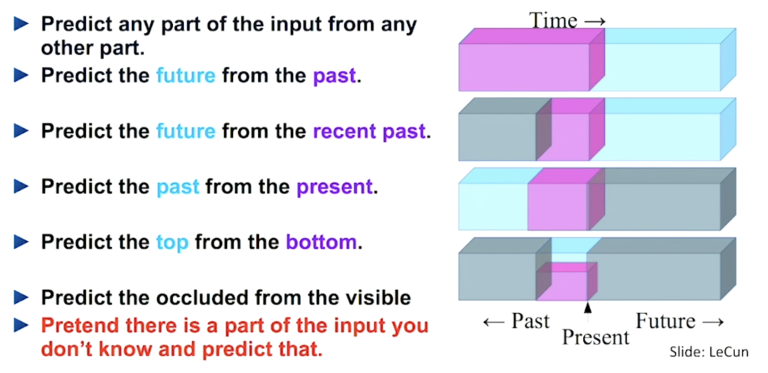

## Why self supervised learing?

* Self-supervised learning is a type of unsupervised learning. It is a way to learn useful features without human annotation.

* Data pre-processing is a time consuming and expensive process. Self-supervised learning can help us to reduce the cost of data preprocessing.



## How self supervised learing works?

write the steps here

* Step 1: Collect the data withour labels
* Step 2: Create a model
* Step 3: Train the model
* Step 4: Fine tune the model for the task we want to solve
* Step 5: Predict the model on test data
* Step 6: Evaluate the model


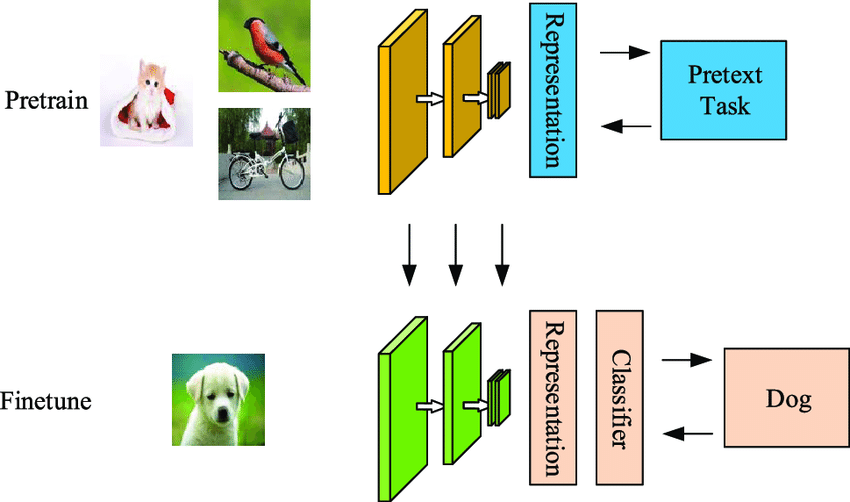

## Task 1: Image Classification using supervised learning 

### data: https://www.kaggle.com/c/dogs-vs-cats/data
### train set size: 10 dog + 10 cat
### test set size: 100 dog+cat


In [111]:
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

In [112]:

train_path = '/home/rishabh.mondal/label_image_FT'



### for class labels 

In [113]:
def class_label(train_path):
    class_labels = {'cat': 0, 'dog': 1}
    image_paths = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_dir = os.path.join(train_path, class_name)
        class_image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
        image_paths.extend(class_image_paths)
        labels.extend([class_label] * len(class_image_paths))
    return image_paths, labels    
    # print('Number of images found: ', len(image_paths))
    # print('number of 0s: ', labels.count(0))
    # print('number of 1s: ', labels.count(1))

### Function for display images 

In [114]:
import random

def display_images(image_paths, labels):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.subplots_adjust(hspace=0.5)
    data = list(zip(image_paths, labels))
    random.shuffle(data)
    image_paths, labels = zip(*data)
    for i in range(10): 
        ax = axes[i // 5, i % 5]
        img = cv2.imread(image_paths[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
        ax.set_title('Label: ' + str(labels[i]))
        ax.axis('off')  


### Evaluate and plot 


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

def evaluate_and_plot(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

20


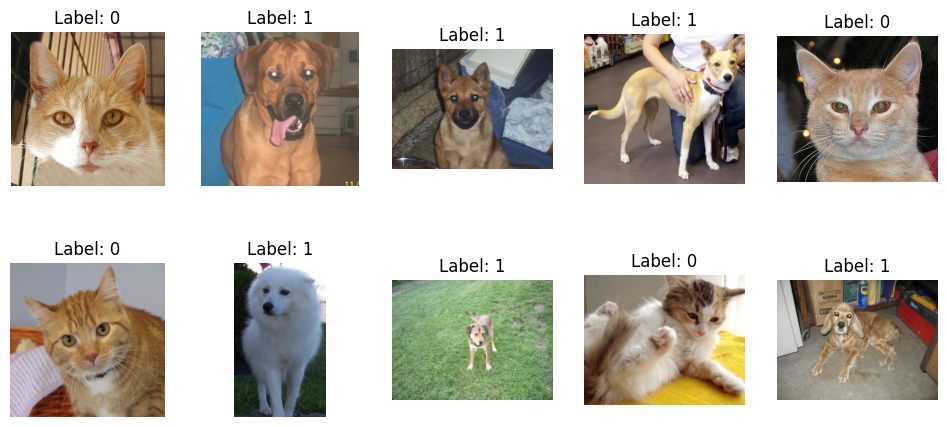

In [116]:

image_paths, labels=class_label(train_path)
display_images(image_paths, labels)
print(len(labels))

### code for transform the data

In [117]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

### trainloader

In [118]:
train_data = datasets.ImageFolder('/home/rishabh.mondal/label_image_FT', transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

### simple vgg like structure

In [119]:
class VGGLike(nn.Module):
    def __init__(self,num_classes):
        super(VGGLike,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


### gpu code

In [120]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [121]:
# print model
model = VGGLike(num_classes=2)
model = model.to(device)
print(model)

VGGLike(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

### model onax representation

In [122]:

# import torch.onnx

# dummy_input = torch.randn(1, 3, 224, 224)  

# # Export the model to ONNX
# onnx_file_path = "your_model.onnx"  
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)
# print("Model exported to ONNX successfully.")


### train loader

In [123]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_list = []
for epoch in range(15):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_list.append(epoch_loss)
    
    print('Epoch: %d | Loss: %.4f' % (epoch + 1, epoch_loss))


Epoch: 1 | Loss: 0.6946
Epoch: 2 | Loss: 0.6937
Epoch: 3 | Loss: 0.6931
Epoch: 4 | Loss: 0.6931
Epoch: 5 | Loss: 0.6926
Epoch: 6 | Loss: 0.6917
Epoch: 7 | Loss: 0.6931
Epoch: 8 | Loss: 0.6930
Epoch: 9 | Loss: 0.6927
Epoch: 10 | Loss: 0.6953
Epoch: 11 | Loss: 0.6951
Epoch: 12 | Loss: 0.6967
Epoch: 13 | Loss: 0.6904
Epoch: 14 | Loss: 0.6955
Epoch: 15 | Loss: 0.6972


In [124]:
torch.save(model.state_dict(), 'model_weights.pth')


### Loss plot

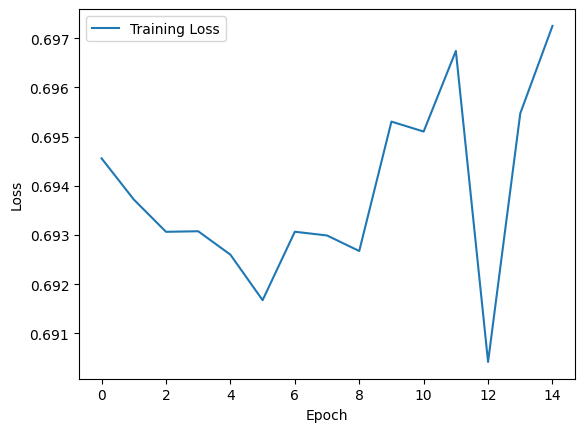

In [125]:
plt.plot(loss_list, label='Training Loss')
# plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [126]:
# predict on test set
test_data = datasets.ImageFolder('/home/rishabh.mondal/test_images_CD', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


In [127]:
image_paths, labels=class_label('/home/rishabh.mondal/test_images_CD')

print(len(labels))

100


In [128]:
model.eval()  
extracted_features = [] 
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:  
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  

        outputs = model(inputs)  
        _, predicted = outputs.max(1)

        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')



Test Accuracy: 60.00%


Accuracy: 0.6
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


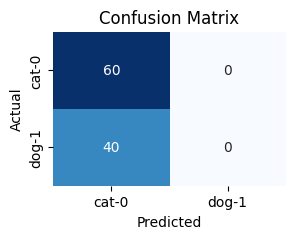

In [129]:
evaluate_and_plot(true_labels, predicted_labels, class_labels=["cat-0", "dog-1"])


In [130]:
def extract_features(model, test_loader):
    features = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  
            model.classifier = model.classifier[:-1]
            # Forward pass to get features
            features.append(model(inputs).cpu().numpy())
    return features

In [131]:
from sklearn.manifold import TSNE


In [136]:
len(labels)
print(labels)

[array(0), array(1), array(1), array(0)]


In [137]:
import numpy as np
features=extract_features(model,test_loader)
features = np.vstack(features)
labels = [label.cpu().numpy() for label in labels]
print(len(labels))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4096 and the array at index 2 has size 25088

In [133]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)


In [134]:
if isinstance(labels, np.ndarray):
    labels = labels.tolist()

colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
color_mapping = {label: color for label, color in zip(labels, colors)}

scatter_colors = [color_mapping[label] for label in labels]

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=scatter_colors)
plt.title('t-SNE Visualization')
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

## Task 2: Image Classification using self supervised learning

### images to grayscale

In [ ]:
import os
from PIL import Image

data_dir = '/home/rishabh.mondal/ssl_dataset'
image_paths = os.listdir(data_dir)

valid_image_paths = []

for img_path in image_paths:
    try:
        Image.open(os.path.join(data_dir, img_path))
        valid_image_paths.append(img_path)
    except Exception as e:
        print(f"Error opening {img_path}: {str(e)}")

print(f"Total images: {len(image_paths)}")
print(f"Valid images: {len(valid_image_paths)}")

# Remove the two problematic image files
problematic_images = ['11702.jpg', '666 - Copy.jpg']
for img in problematic_images:
    if img in valid_image_paths:
        valid_image_paths.remove(img)

print(f"Valid images after removal: {len(valid_image_paths)}")

# Now, you can create your dataset with the updated valid image paths.


Total images: 9998
Valid images: 9998
Valid images after removal: 9998


In [ ]:


class UnlabeledColorizationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_paths = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        color_image = Image.open(img_path)

        # Convert the color image to RGB format (3 channels)
        color_image = color_image.convert('RGB')

        if self.transform:
            color_image = self.transform(color_image)

        transform = transforms.Grayscale(num_output_channels=1)
        grayscale_image = transform(color_image)

        return grayscale_image, color_image


torch.Size([1, 224, 224])
torch.Size([3, 224, 224])


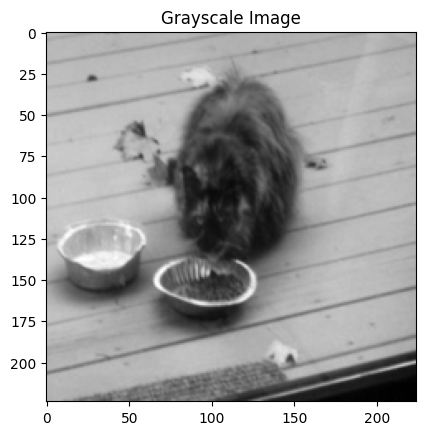

In [ ]:
unlabeled_data = UnlabeledColorizationDataset('/home/rishabh.mondal/ssl_dataset/', transform=transform)
len(unlabeled_data)
#show the image
grayscale_image, color_image = unlabeled_data[0]
plt.imshow(grayscale_image.squeeze(), cmap='gray')
plt.title('Grayscale Image')
#show the dimension of the image
print(grayscale_image.shape)
print(color_image.shape)

### model for image colorization 